In [1]:
from torch_geometric.datasets import NELL
from torch_geometric.datasets import KarateClub
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
import torch

dataset = KarateClub()

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
# data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [2]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class SAGE(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super(SAGE,self).__init__()    # 构造函数

        self.conv1 = SAGEConv(in_channels=in_c, out_channels=hid_c)
        self.conv2 = SAGEConv(in_channels=hid_c, out_channels=out_c)
  
    def forward(self, data):
        x, edge_index = data.x, data.edge_index    # x:节点特征矩阵; edge_index:COO格式的图形连接，维度[2,边的数量]，数据：[ [源节点],[目标节点] ]
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        
        x1 = F.log_softmax(x, dim=1)
        
        return x1, x

model = SAGE(in_c=dataset.num_node_features,hid_c=100,out_c=dataset.num_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
print(model(data))

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out1, out = model(data)
    # 交叉熵损失
    loss = F.nll_loss(out1[data.train_mask], data.y[data.train_mask])       # 负对数似然。
    loss.backward()
    optimizer.step()
    print('epoch:',epoch, 'loss:',loss.item())  

print(out)

(tensor([[-3.3860, -3.5249, -3.4277,  ..., -3.5709, -3.5910, -3.5579],
        [-3.4776, -3.5409, -3.4814,  ..., -3.5509, -3.6132, -3.5509],
        [-3.4031, -3.4791, -3.3990,  ..., -3.5526, -3.6344, -3.5699],
        ...,
        [-3.4751, -3.5127, -3.4639,  ..., -3.5435, -3.6171, -3.5531],
        [-3.4336, -3.4713, -3.4610,  ..., -3.6113, -3.6030, -3.5439],
        [-3.4483, -3.4836, -3.4177,  ..., -3.6024, -3.5996, -3.5670]],
       grad_fn=<LogSoftmaxBackward>), tensor([[ 0.1497,  0.0108,  0.1081,  ..., -0.0351, -0.0552, -0.0221],
        [ 0.0554, -0.0078,  0.0517,  ..., -0.0178, -0.0801, -0.0178],
        [ 0.1402,  0.0641,  0.1442,  ..., -0.0093, -0.0911, -0.0266],
        ...,
        [ 0.0523,  0.0147,  0.0635,  ..., -0.0160, -0.0897, -0.0256],
        [ 0.1029,  0.0653,  0.0755,  ..., -0.0748, -0.0665, -0.0073],
        [ 0.0918,  0.0564,  0.1223,  ..., -0.0624, -0.0596, -0.0270]],
       grad_fn=<AddBackward0>))
epoch: 0 loss: 3.4975829124450684
epoch: 1 loss: 3.4656019210

epoch: 207 loss: 0.01981741562485695
epoch: 208 loss: 0.0195519607514143
epoch: 209 loss: 0.019292399287223816
epoch: 210 loss: 0.019038066267967224
epoch: 211 loss: 0.018789660185575485
epoch: 212 loss: 0.018546780571341515
epoch: 213 loss: 0.01830875501036644
epoch: 214 loss: 0.018075473606586456
epoch: 215 loss: 0.017847610637545586
epoch: 216 loss: 0.0176241472363472
epoch: 217 loss: 0.017405521124601364
epoch: 218 loss: 0.0171914491802454
epoch: 219 loss: 0.016981814056634903
epoch: 220 loss: 0.016776148229837418
epoch: 221 loss: 0.016574982553720474
epoch: 222 loss: 0.016378644853830338
epoch: 223 loss: 0.016185812652111053
epoch: 224 loss: 0.015996525064110756
epoch: 225 loss: 0.01581239327788353
epoch: 226 loss: 0.01563112810254097
epoch: 227 loss: 0.015453588217496872
epoch: 228 loss: 0.01527950819581747
epoch: 229 loss: 0.015108277089893818
epoch: 230 loss: 0.014941154047846794
epoch: 231 loss: 0.01477658748626709
epoch: 232 loss: 0.014615724794566631
epoch: 233 loss: 0.01445

epoch: 485 loss: 0.00340354535728693
epoch: 486 loss: 0.003395646344870329
epoch: 487 loss: 0.0033880737610161304
epoch: 488 loss: 0.00338088721036911
epoch: 489 loss: 0.0033734035678207874
epoch: 490 loss: 0.0033660694025456905
epoch: 491 loss: 0.003358853282406926
epoch: 492 loss: 0.0033517256379127502
epoch: 493 loss: 0.003344687633216381
epoch: 494 loss: 0.003337530419230461
epoch: 495 loss: 0.0033305520191788673
epoch: 496 loss: 0.0033236625604331493
epoch: 497 loss: 0.00331689091399312
epoch: 498 loss: 0.003310149535536766
epoch: 499 loss: 0.0033031413331627846
tensor([[-0.1705,  6.7791, -0.1152,  ..., -3.0895, -3.2151, -3.1585],
        [ 2.0374,  3.1059, -0.2052,  ..., -3.1716, -3.1443, -3.1539],
        [ 1.7285,  3.1283,  0.9923,  ..., -3.1005, -3.2036, -3.1178],
        ...,
        [ 2.1793,  0.7096,  1.7521,  ..., -2.9551, -2.9261, -2.9966],
        [ 1.9546,  2.6964,  1.0602,  ..., -2.8685, -2.9935, -2.8596],
        [ 1.4250,  2.8942,  1.2392,  ..., -2.7956, -2.9375, -2.

In [3]:
import pandas as pd
from sklearn import cluster
from sklearn import metrics

out=out.cpu().detach().numpy()
model = cluster.KMeans(n_clusters=4)
model.fit(out)

y_predict = model.predict(out)

# Calinski-Harabaz Index：越大越好
# Silhouette Coefficient：轮廓系数（越大越好)
print('Calinski-Harabaz Index：',metrics.calinski_harabasz_score(out,y_predict))
print('Silhouette Coefficient：',metrics.silhouette_score(out,y_predict))

Calinski-Harabaz Index： 14.700669094454609
Silhouette Coefficient： 0.35009575


In [4]:
from sklearn.manifold import TSNE
t_sne = TSNE()
data=t_sne.fit_transform(out)
data=pd.DataFrame(data)
data = pd.DataFrame(data,index=y_predict)
data_tsne = pd.DataFrame(t_sne.embedding_, index =y_predict)
data_tsne

,0,1
3,170.709259,16.812178
3,9.037280,39.837204
3,61.188454,-28.854555
3,-28.987829,-23.672665
1,-133.402161,-147.067001
1,52.495529,150.127151
3,60.521305,-82.852417
1,-32.260651,24.366505
0,-181.942215,36.280582
0,-28.685383,79.784592


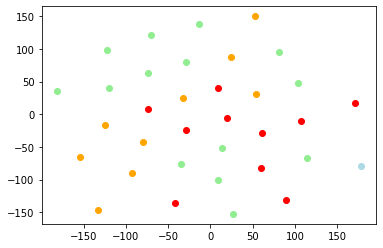

In [5]:
from matplotlib import pyplot as plt
d = data_tsne[data_tsne.index == 0]     #找出聚类类别为0的数据对应的降维结果
plt.scatter(d[0], d[1],c='lightgreen',marker='o')
d = data_tsne[data_tsne.index == 1]
plt.scatter(d[0], d[1], c='orange',	marker='o')
d = data_tsne[data_tsne.index == 2]
plt.scatter(d[0], d[1], c='lightblue',marker='o')
d = data_tsne[data_tsne.index == 3]
plt.scatter(d[0], d[1], c='red',marker='o')